In [1]:
#General Imports
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate

In [2]:
dataset_fpath = '../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = pd.read_csv(dataset_fpath, compression = 'zip', low_memory=False)

# Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of Dataset: {nidd_dataset.shape}")

print(f'\nDataset Information:')
nidd_dataset.info()

# print(f'\nDataset Description:')
# print(nidd_dataset.describe())

print(f'\nNumber of NULL values per column:')
print(nidd_dataset.isnull().sum())

print(f'\nNumber of unique values per column:')
print(nidd_dataset.nunique())

Original shape of Dataset: (1215890, 106)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Columns: 106 entries, SrcId to Label
dtypes: float64(66), int64(24), object(16)
memory usage: 983.3+ MB

Number of NULL values per column:
SrcId             0
Rank              0
StartTime         0
LastTime          0
Trans             0
              ...  
TcpRtt            0
SynAck            0
AckDat            0
TcpOpt       938654
Label             0
Length: 106, dtype: int64

Number of unique values per column:
SrcId             1
Rank         467717
StartTime     32888
LastTime      32828
Trans             1
              ...  
TcpRtt        18745
SynAck         3896
AckDat        23870
TcpOpt            7
Label             2
Length: 106, dtype: int64


### Dropping Features with the following properties:
    - Having NaN values above 95% of their total values
    - Having Zero values above 95% of their total values
    - Having constant values 

In [3]:
# Dictionary to store dropped features based on different criteria
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}

# Dictionary to store preprocessing time
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Time <Filling NaNs>": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.}

# Record the starting time for dropping features based on "bad" values
t0 = time()

# Dropping columns with more than 95% NaN values
threshold_nans = 0.95 * nidd_dataset.shape[0]
columns_Nan_to_drop = nidd_dataset.columns[nidd_dataset.isna().sum() > threshold_nans]
features_dropped["Nan columns"].extend(columns_Nan_to_drop)
nidd_dataset_cleaned_nan = nidd_dataset.drop(columns=columns_Nan_to_drop)
# Alternatively, you can use:
# nidd_dataset_cleaned_nan = nidd_dataset.dropna(thresh=ceil(1 - threshold_nans), axis=1)
print(f"After dropping NaN columns: {nidd_dataset_cleaned_nan.shape}")

# Dropping columns with more than 95% zero values
threshold_zeros = 0.95 * nidd_dataset.shape[0]
zero_counts = nidd_dataset_cleaned_nan.apply(lambda col: (col == 0).sum())
columns_zeros_to_drop = zero_counts[zero_counts > threshold_zeros].index
features_dropped["Zero columns"].extend(columns_zeros_to_drop)
nidd_dataset_cleaned_zeros = nidd_dataset_cleaned_nan.drop(columns_zeros_to_drop, axis=1)
print(f"After dropping NaN & Zero columns: {nidd_dataset_cleaned_zeros.shape}")

# Dropping constant columns
constant_columns = nidd_dataset_cleaned_zeros.columns[nidd_dataset_cleaned_zeros.nunique() == 1]
features_dropped["Constant columns"].extend(constant_columns)
nidd_dataset_cleaned = nidd_dataset_cleaned_zeros.drop(columns=constant_columns)
print(f"After dropping NaN & Zero & Constant columns: {nidd_dataset_cleaned.shape}")

# Record the ending time for dropping features based on "bad" values
t1 = time()

# Calculate and print the time taken for the dropping features step
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = t1 - t0
print(f"Time <Dropping features based on a threshold `bad` values>: {preprocessing_d['Time <Dropping features based on a threshold `bad` values>']:.3f} seconds")

After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)
Time <Dropping features based on a threshold `bad` values>: 2.905 seconds


### Replacing NaN values & label encoding categorical features:
    - Numerical features with their mean
    - Categorical features with the most frequent category


In [4]:
# Record the starting time for filling NaN values
t0 = time()

# Get numeric and categorical columns
numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

# Fill NaN values in numeric columns with mean
numeric_cols_mean = nidd_dataset_cleaned[numeric_cols].mean()
nidd_dataset_cleaned[numeric_cols] = nidd_dataset_cleaned[numeric_cols].fillna(numeric_cols_mean)

# Fill NaN values in categorical columns with mode
# iloc[0] is used to get the first element of the series in case there is more than one mode.
categorical_cols_mode = nidd_dataset_cleaned[categorical_cols].mode().iloc[0]
nidd_dataset_cleaned[categorical_cols] = nidd_dataset_cleaned[categorical_cols].fillna(categorical_cols_mode)

# Record the ending time for filling NaN values
t1 = time()
preprocessing_d["Time <Filling NaNs>"] = t1 - t0

# Print the time taken for filling NaN values
print(f"Time <Filling NaNs>: {preprocessing_d['Time <Filling NaNs>']:.3f} seconds")

# Record the starting time for encoding categorical features
t0 = time()

# Encoding categorical columns using LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

# Record the ending time for encoding categorical features
t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0

# Print the time taken for encoding categorical features
print(f"Time <Encoding categorical features>: {preprocessing_d['Time <Encoding categorical features>']:.3f} seconds")

Time <Filling NaNs>: 2.460 seconds
Time <Encoding categorical features>: 1.918 seconds


### Calculating the Pearson Correlation matrix and plotting its Heatmap
    We find the pairwise corellation for every single pair of features. We also consider absolute values
    so as to include high negative correlation as well. Based on a threshold(0.9 here) we remove one feature
    from each pair(the one having the lowest correlation )

Final shape of cleaned DataFrame after removing correlated features based on Pearson method: (1215890, 36)


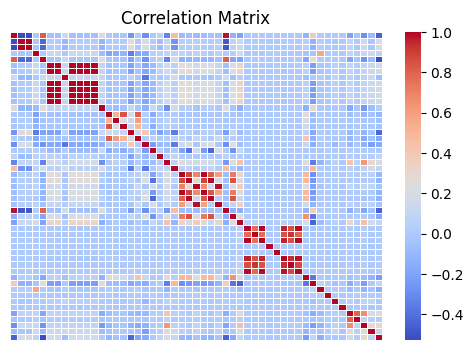

In [5]:
t0 = time()

# Define the target column for correlation analysis
target_col = nidd_dataset_cleaned.columns[-1] # eq: TARGET

# Calculate the correlation matrix using Pearson method
correlation_matrix = nidd_dataset_cleaned.corr(method='pearson')

# Set the correlation threshold for feature selection
corr_threshold = 0.9

# Identify pairs of features with high correlation
high_corr_pairs = correlation_matrix.iloc[:, :-1].abs() > corr_threshold

# Initialize a set to store features to be dropped (avoiding duplicates)
features_to_drop = set()

# Iterate through the pairs of highly correlated features
for feature_on_col in high_corr_pairs.columns:
    for feature_in_row in high_corr_pairs.index[high_corr_pairs[feature_on_col]]:
        if feature_on_col != feature_in_row:  # Avoid comparisons between the same pairs
            # Get the correlation values for each feature against the target variable
            feature_in_row_cor_val = correlation_matrix.loc[feature_in_row, target_col]
            feature_on_col_cor_val = correlation_matrix.loc[feature_on_col, target_col]
            
            # Check if the correlation signs are the same
            same_corellation_sign = feature_in_row_cor_val * feature_on_col_cor_val > 0
            
            # If the signs are the same, keep the feature with the higher absolute correlation
            if same_corellation_sign:
                if abs(feature_in_row_cor_val) > abs(feature_on_col_cor_val):
                    features_to_drop.add(feature_on_col)
                else:
                    features_to_drop.add(feature_in_row)

# Drop the identified features with high correlation
nidd_dataset_filtered = nidd_dataset_cleaned.drop(columns=list(features_to_drop))

t1 = time()

# Update the total preprocessing time for feature selection
preprocessing_d["Time <Feature selection>"] += t1 - t0

# Print the final shape of the cleaned DataFrame after removing correlated features
print(f"Final shape of cleaned DataFrame after removing correlated features based on Pearson method: {nidd_dataset_filtered.shape}")

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', 
            fmt='.2f', xticklabels=False, yticklabels=False,
            linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


### Using Anova F-test to calculate a score that quantifies changes in mean and variance against the target variable

In [6]:
# Separate features (X) and target variable (y)
X = nidd_dataset_filtered.drop(columns=[target_col])
y = nidd_dataset_filtered[target_col]

# Record the starting time for ANOVA F-score feature selection
t0 = time()

# Calculate ANOVA F-scores
f_scores, _ = f_classif(X, y)
# Create a DataFrame to store feature names and their corresponding F-scores
results_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})
# Sort the DataFrame based on F-scores in descending order
results_df = results_df.sort_values(by='F-Score', ascending=False)

# Record the ending time for ANOVA F-score feature selection
t1 = time()
preprocessing_d["Time <Feature selection>"] += t1-t0

# Select the top 10 features based on ANOVA F-scores
top_10_features = results_df.head(10)

# Print the top 10 features and their corresponding F-scores
print("Top 10 Features based on ANOVA F-scores:")
for index, row in top_10_features.iterrows():
    print(f"{row['Feature']}: {row['F-Score']}")

# Print the time taken for feature selection
print(f"\nTime <Feature selection>: {preprocessing_d['Time <Feature selection>']:.3f} seconds")

Top 10 Features based on ANOVA F-scores:
Seq: 469849.6390666038
Offset: 319314.40971959295
sTtl: 271902.447512305
AckDat: 114843.30885848559
Dir: 67629.15152188136
StartTime: 54826.22943189787
dIpId: 53749.31118614725
TcpRtt: 48169.83238437568
dTtl: 40155.94625566492
sMeanPktSz: 38473.44797186211

Time <Feature selection>: 5.591 seconds


In [7]:
top_10_features_cols = top_10_features['Feature'].tolist()
# import joblib

# with open("../RandomForest.pkl","wb") as file:
#     joblib.dump(pipeline, file)


# with open("../models/top_10_features_cols.pkl","wb") as file:
#     joblib.dump(top_10_features_cols, file)

# X_train, X_test, y_train, y_test = train_test_split(nidd_dataset[top_10_features_cols], 
#                                                     nidd_dataset[TARGET]
#                                                     ,test_size=0.3, random_state=rnd.seed(42)) 

# with open("../data/test_sample2.csv", "wb") as file:
#     X_test.to_csv(file)
# with open("../data/test_sample2_target.csv", "wb") as file:
#     y_test.to_csv(file)

In [29]:
# Extract top 10 feature columns from the DataFrame
top_10_features_cols = top_10_features['Feature'].tolist()

# Extract target variable and features' values based on top 10 features
target = nidd_dataset[TARGET]
features = nidd_dataset[top_10_features_cols]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=rnd.seed(42)) 

# Identify numeric and categorical features within the top 10 features
numeric_features = list(set(numeric_cols) & set(top_10_features_cols))
categorical_features = list(set(categorical_cols) & set(top_10_features_cols))


# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

# Create a ColumnTransformer to apply different transformers to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        
    ])

# Create a pipeline that includes preprocessing and a RandomForestClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
predictions = pipeline.predict(X_test)


### Applying Z-normalization to the selected features, training a RandomForest classifier

In [9]:
# # Extract top 10 feature columns from the DataFrame
# top_10_features_cols = top_10_features['Feature'].tolist()

# # Extract target variable and features' values based on top 10 features
# target = nidd_dataset[TARGET]
# features = nidd_dataset[top_10_features_cols]

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=rnd.seed(42)) 

# # Identify numeric and categorical features within the top 10 features
# numeric_features = list(set(numeric_cols) & set(top_10_features_cols))
# categorical_features = list(set(categorical_cols) & set(top_10_features_cols))


# # Create transformers for numeric and categorical features
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')), 
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),  
#     ('encoder', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Create a ColumnTransformer to apply different transformers to numeric and categorical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
        
#     ])

# # Create a pipeline that includes preprocessing and a RandomForestClassifier
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Fit the pipeline on the training data
# pipeline.fit(X_train, y_train)

# # Make predictions on the test data
# predictions = pipeline.predict(X_test)


### Plotting Confusion Matrix and classification report

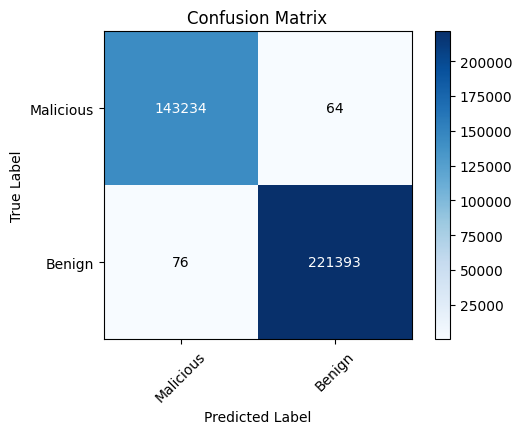

Classification Report:
               precision    recall  f1-score   support

   Malicious   0.999553  0.999470  0.999512    143310
      Benign   0.999657  0.999711  0.999684    221457

    accuracy                       0.999616    364767
   macro avg   0.999605  0.999590  0.999598    364767
weighted avg   0.999616  0.999616  0.999616    364767

Time <Dropping features based on a threshold `bad` values>: 2.9054 seconds
Time <Filling NaNs>: 2.4600 seconds
Time <Encoding categorical features>: 1.9182 seconds
Time <Feature selection>: 5.5907 seconds


In [30]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Get the unique categories in the target variable
target_categories = set(nidd_dataset[TARGET])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# Generate and print the classification report
class_report = classification_report(predictions, y_test, target_names=target_categories, digits=6)
print("Classification Report:\n", class_report)

# Print the preprocessing times
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")

      Feature  Importance
3      AckDat    0.352981
2        sTtl    0.214813
1      Offset    0.156378
6       dIpId    0.123114
9  sMeanPktSz    0.053512
0         Seq    0.036774
5   StartTime    0.024879
4         Dir    0.022574
7      TcpRtt    0.011731
8        dTtl    0.003244


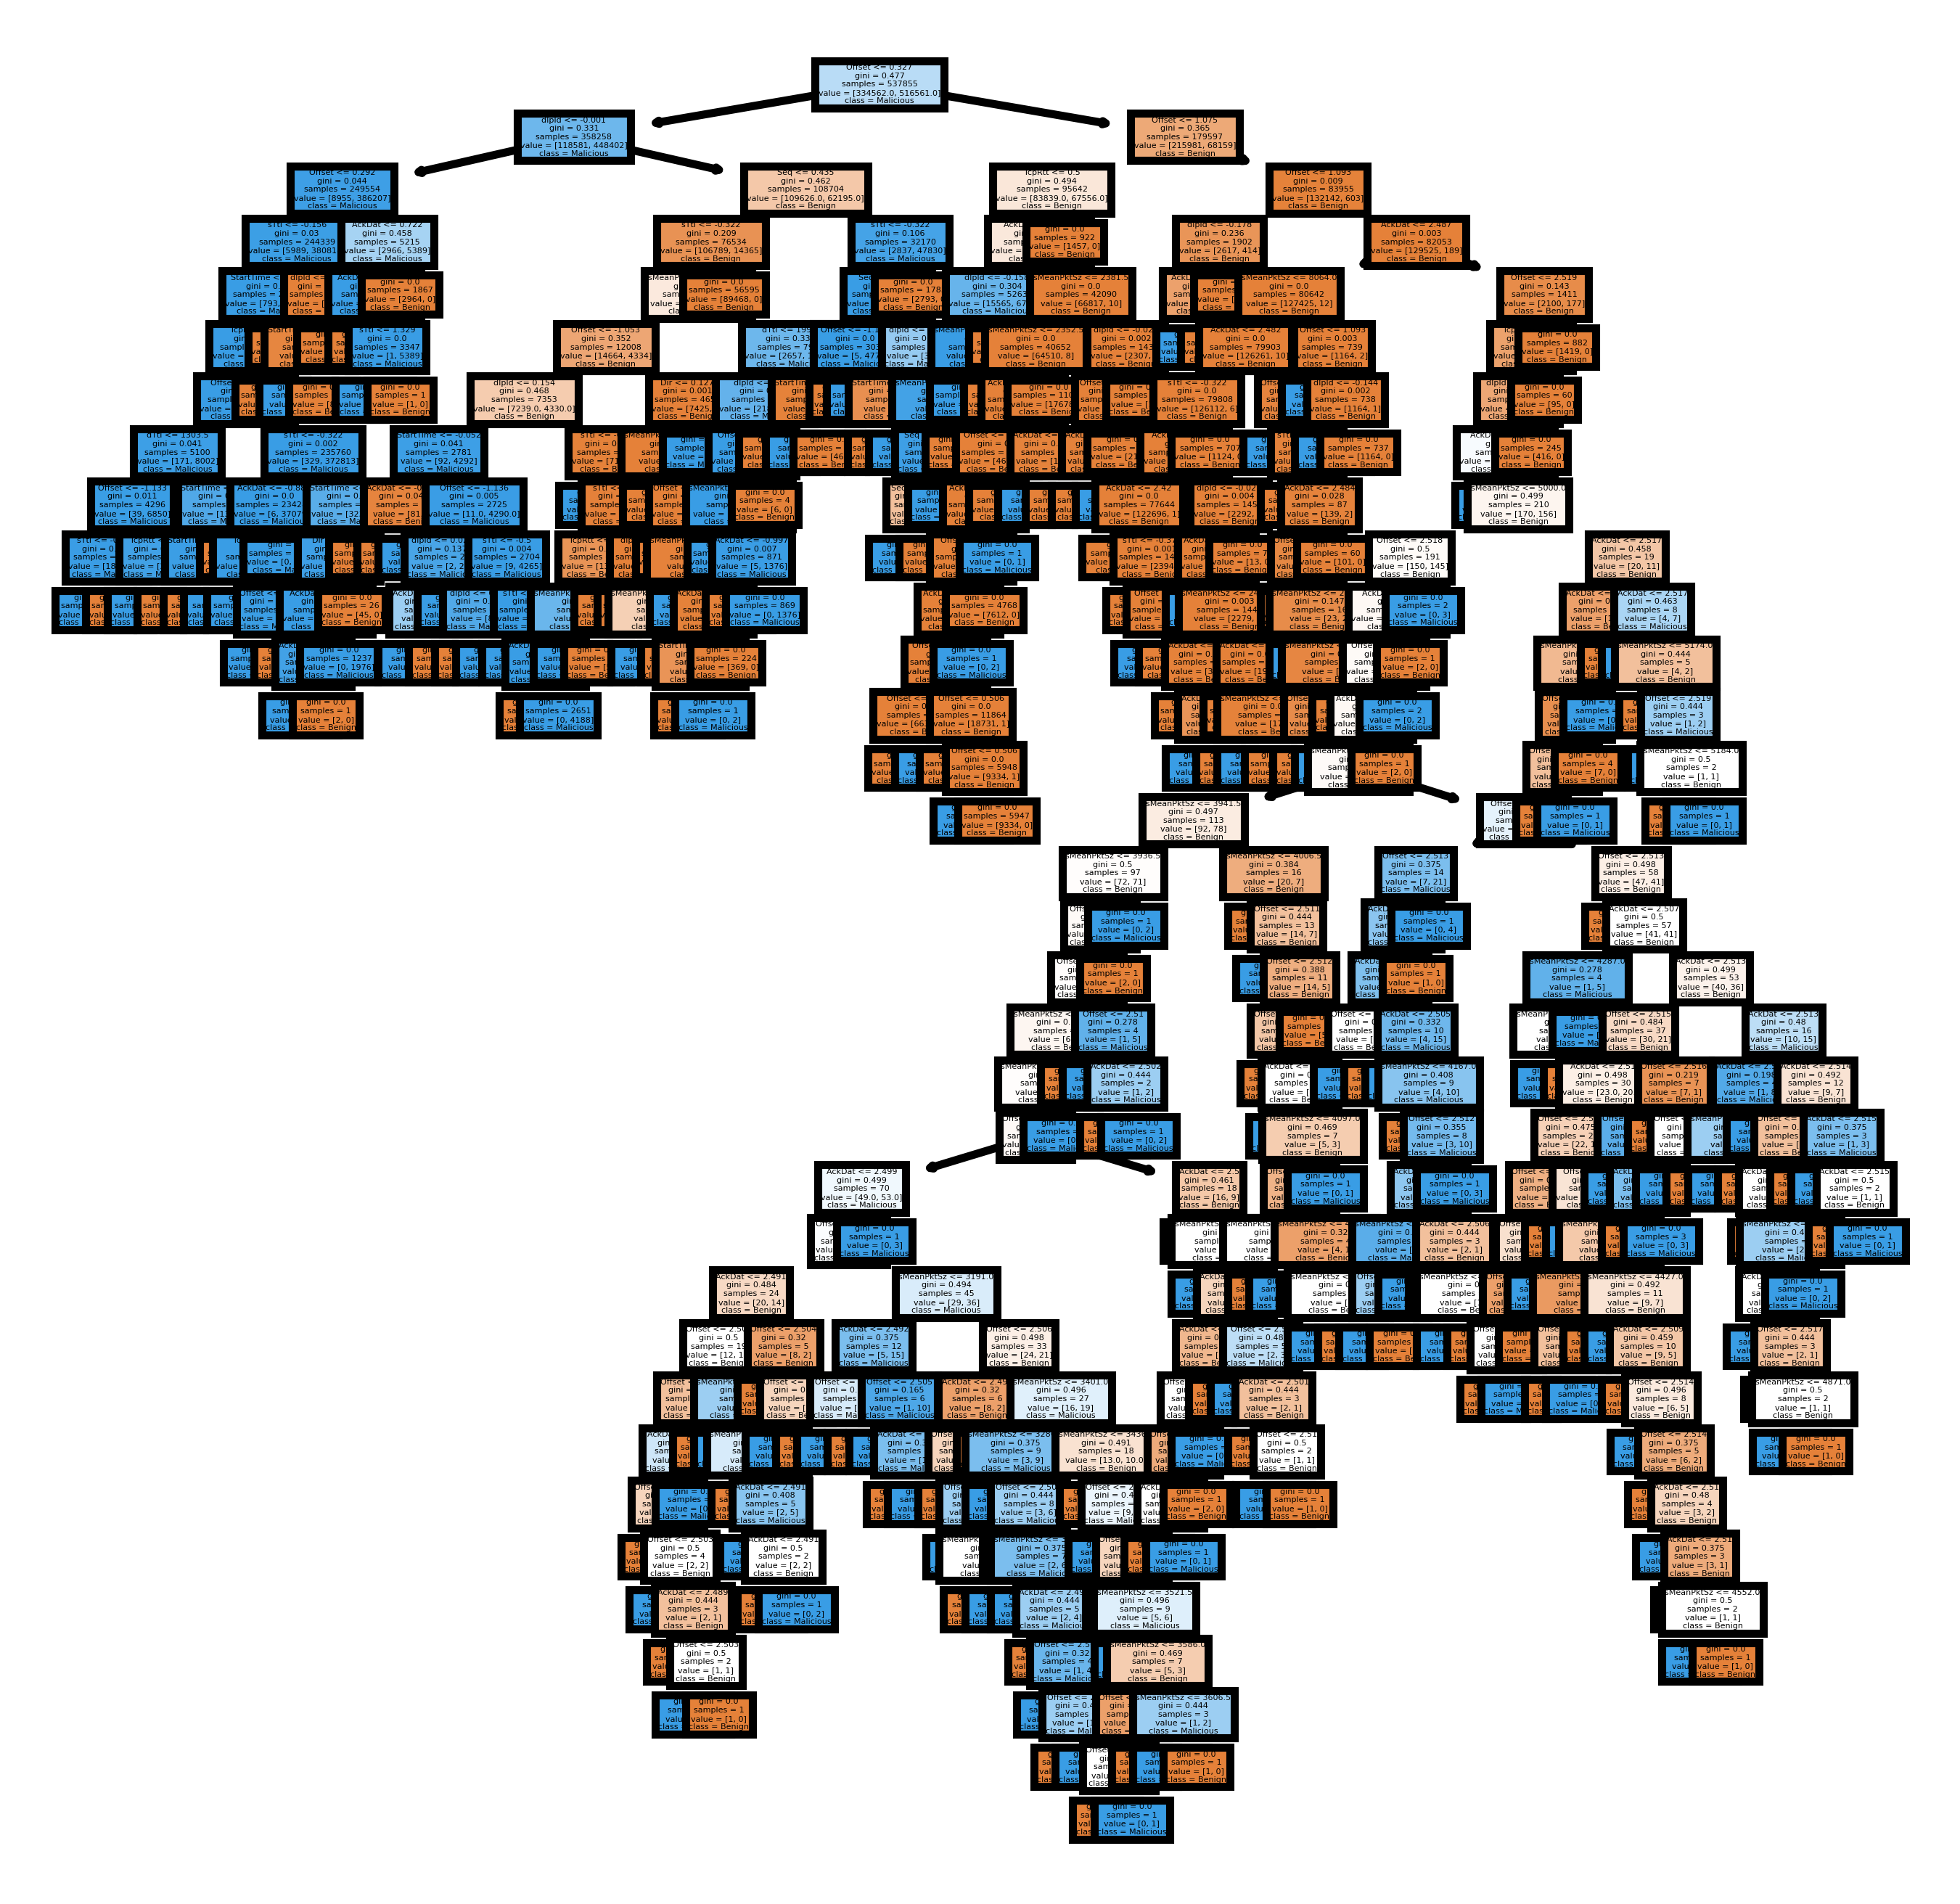

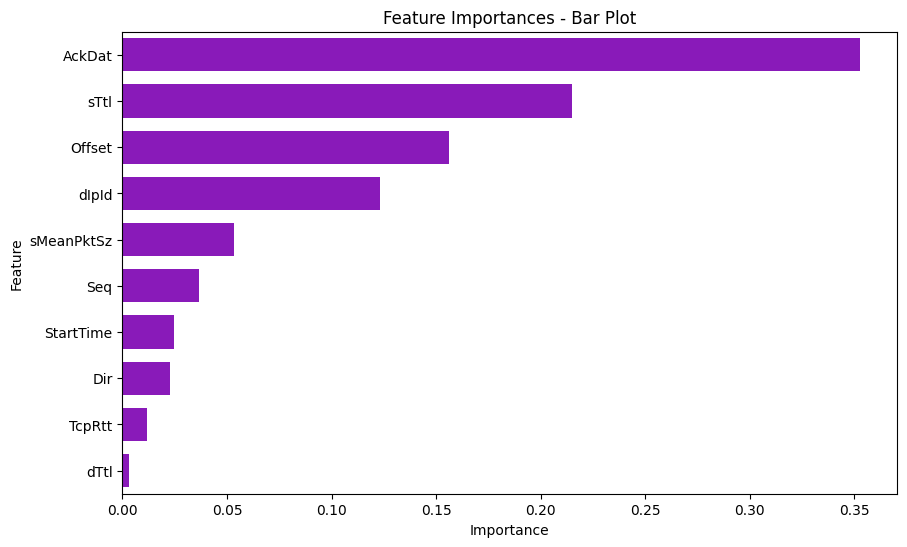

In [31]:
from sklearn import tree


fn=X_test.columns
cn=pipeline['classifier'].classes_
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(pipeline['classifier'].estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True)
# fig.savefig('rf_tree.png')


rf = pipeline['classifier']
data = list(zip(top_10_features_cols, rf.feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
print(df_importances)


# print(f"Feature importance: {feature_importances_}")
# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', 
            data=df_importances,
            width = 1.2, gap = 0.4,
            color = "darkviolet")
plt.title('Feature Importances - Bar Plot')
plt.show()

### 5-Fold cross Validation

In [32]:


scores = ["accuracy","f1", "precision_macro", "recall_macro"]
pipeline_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
scores = cross_validate(pipeline_cv, nidd_dataset_filtered[top_10_features_cols], nidd_dataset[TARGET], 
               cv=5, scoring=scores, return_train_score=True)



/home/dimet/Documents/Dimitris/ceid/5G_Intrusion_detection/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dimet/Documents/Dimitris/ceid/5G_Intrusion_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
  File "/home/dimet/Documents/Dimitris/ceid/5G_Intrusion_detection/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/dimet/Documents/Dimitris/ceid/5G_Intrusion_detection/venv/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/home/dimet/Documents/Dimitris/ceid/5G_Intrusion_detection/venv/lib/python3.10/site-packages/sklearn/met

In [33]:
import joblib
with open("../cross_validation_scores5ORD.pkl","wb") as file:
    joblib.dump(scores, file)

print(scores.keys())
# print(len(scores['train_accuracy']))
print(f"Train accuracy mean: {scores['train_accuracy'].mean()}\n Test accuracy mean: {scores['test_accuracy'].mean()}")
print(f"F1 mean: {scores['test_f1']}\n Precision mean: {scores['test_precision_macro'].mean()}\n Recall mean: {scores['test_recall_macro'].mean()}")

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1', 'test_precision_macro', 'train_precision_macro', 'test_recall_macro', 'train_recall_macro'])
Train accuracy mean: 1.0
 Test accuracy mean: 0.9269004597455363
F1 mean: [nan nan nan nan nan]
 Precision mean: 0.951899745640136
 Recall mean: 0.9090942047055481
